In [2]:
import sys
sys.path.append("..")


In [ ]:
import argparse
import numpy as np
import torch
from os.path import isdir
import os
import import_ipynb
from modelsAndFunctions.models_convlstm import ConvLSTM
from modelsAndFunctions.functions import *
from torch.utils import data
from torch import nn, optim
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def get_data(data_input, data_label, args):
    # data_input:(N, C, T, D), data_label:(N, T, 1)
    data_loader = data.DataLoader(data.TensorDataset(data_input, data_label), batch_size=args.batch_size, shuffle=False, drop_last=False)
    return data_loader

In [9]:
def get_models(args):
    if args.test_checkpoint is None:
        net = ConvLSTM(input_channels=1, hidden_channels=[16, 8, 1], kernel_size=5, in_dim=15, out_dim=1, step=10)
        optimizer = optim.Adam(list(net.parameters()), amsgrad=True, lr=args.learning_rate)
    else:
        try:
            net = torch.load("/main/checkpoints/" + args.test_checkpoint + "_net")
            optimizer = torch.load("/main/checkpoints/" + args.test_checkpoint + "_optimizer")
        except FileNotFoundError:
            try:
                net = torch.load(args.test_checkpoint + "_net")
                optimizer = torch.load(args.test_checkpoint + "_optimizer")
            except:
                print("No checkpoint found at '{}'- Please specify the model for testing".format(args.test_checkpoint))
                exit()

    if torch.cuda.is_available():
        net.cuda()

    return net, optimizer

In [5]:
def train(train_loader, args):
    net, optimizer = get_models(args)
    net.train()
    criterion = nn.MSELoss()

    # make a directory to save models if it doesn't exist
    if not isdir("checkpoints"):
        os.mkdir("checkpoints")

    print("Training the model")
    loss_var = []
    for epoch in tqdm(range(args.max_epoch)):
        train_loss = []
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = net(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().clone())
        train_loss = torch.tensor(train_loss)
        epoch_loss = torch.mean(train_loss).squeeze()
        loss_var.append(epoch_loss)
    loss_var = torch.tensor(loss_var)
    loss_var = loss_var.numpy()

    plt.plot(np.arange(args.max_epoch), loss_var)
    plt.title("Training Curve")
    plt.show()

    torch.save(net, "checkpoints/{}_net".format(args.session_name))
    torch.save(optimizer, "checkpoints/{}_optimizer".format(args.session_name))

In [6]:
def test(test_loader, args):
    if args.test_checkpoint is None:
        args.test_checkpoint = "checkpoints/{}".format(args.session_name)
    model, _ = get_models(args)
    criterion = nn.MSELoss()
    model.eval()

    true_price = []
    estimate_price = []

    test_loss = []
    test_map = []
    test_mape = []
    test_property_corr = []

    model.eval()
    print("\nTesting the model")
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x)
            y = test_label_normalization.unnormalize(y)
            y_hat = test_label_normalization.unnormalize(y_hat)
            loss = criterion(y, y_hat)
            corr, map, mape = metrics(y_hat.detach(), y.detach())

            test_loss.append(loss.item())
            test_map.append(map)
            test_mape.append(mape)
            test_property_corr.append(corr)

            true_price.append(y.detach())
            estimate_price.append(y_hat.detach())

        property_corr = torch.mean(torch.cat(test_property_corr, dim=0)).squeeze().float().cuda()
        map = torch.mean(torch.cat(test_map, dim=0)).squeeze().float().cuda()
        mape = torch.mean(torch.cat(test_mape, dim=0)).squeeze().float().cuda()
        loss = torch.mean(torch.tensor(test_loss)).float().cuda()
        rmse = torch.sqrt(loss)
        print("MSE: {:.5f}\nRMSE: {:0.5f}\nMAP: {:0.5f}\nMAPE: {:0.5f}\nCorrelation: {:0.5f}\n".format(loss, rmse, map, mape, property_corr))

        # shape:(N, T, D_out=3)
        true_price = torch.cat(true_price, dim=0)
        estimate_price = torch.cat(estimate_price, dim=0)

        true_price = true_price.cpu()
        estimate_price = estimate_price.cpu()

        true_price = true_price.numpy()
        estimate_price = estimate_price.numpy()

        plot_len = 120
        plt.plot(np.arange(plot_len), true_price[0:plot_len], color='blue', label="True Price")
        plt.plot(np.arange(plot_len), estimate_price[0:plot_len], color='red', label="Estimated Price")
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Option Price')
        plt.title("Comparison of Estimated Price and True Price")

        plt.show()
    return true_price, estimate_price

C:\Users\86166\AppData\Local\Temp\ipykernel_22852\537507508.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_input = torch.load(r"E:\pyProjects\3DTensor-basedDL4Op

Training the model


100%|██████████| 200/200 [33:25<00:00, 10.03s/it]


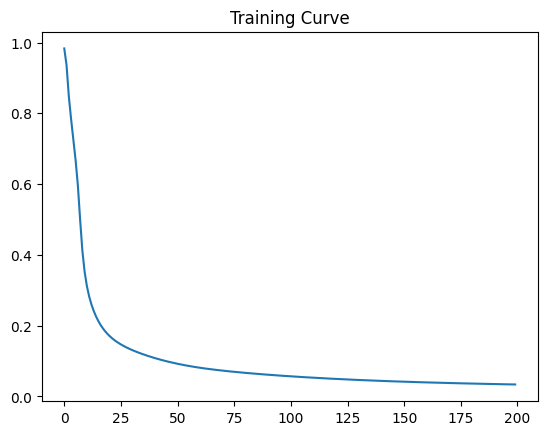

C:\Users\86166\AppData\Local\Temp\ipykernel_22852\412152752.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load("/main/checkpoints/" + args.test_checkpoint 


Testing the model
MSE: 0.00821
RMSE: 0.09059
MAP: 0.05951
MAPE: 6.63525
Correlation: 0.81289



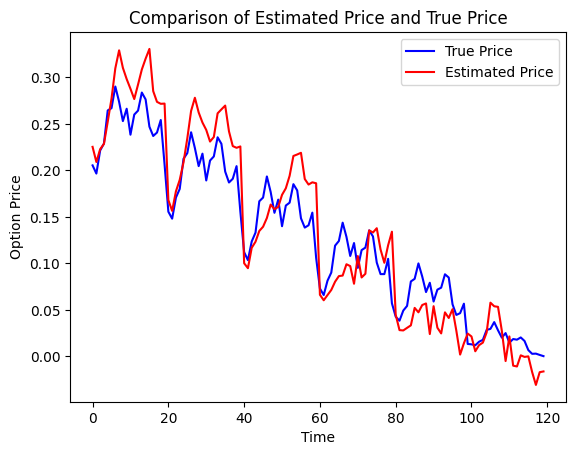

In [ ]:
if __name__ == '__main__':
    class Args:
        learning_rate = 0.0001
        max_epoch = 200
        batch_size = 256
        session_name = datetime.now().strftime('%b%d_%H%M%S')
        test_checkpoint = None
        nonlinearity = "tanh"
    
    args = Args()  # 创建参数对象
    
# cnnRNN convlstm训练时无需validation集 学习率 验证误差时 才需要
    train_input = torch.load(r".\3DTensor-basedDL4OptionPricing\data_ipynb\torch-data-ipynb\train_input.pt").float().cuda()

    train_input_mean = torch.mean(train_input, dim=0, keepdim=True).float()
    train_input_std = torch.std(train_input, dim=0, keepdim=True).float()
    train_input_normalization = Normalization(train_input_mean, train_input_std)
    train_input = train_input_normalization.normalize(train_input)

    train_label = torch.load(r".\3DTensor-basedDL4OptionPricing\data_ipynb\torch-data-ipynb\train_label.pt").float().cuda()
    train_label_mean = torch.mean(train_label, dim=0, keepdim=False)
    train_label_std = torch.std(train_label, dim=0, keepdim=False)
    train_label_normalization = Normalization(train_label_mean, train_label_std)
    train_label = train_label_normalization.normalize(train_label)

    test_input = torch.load(r".\3DTensor-basedDL4OptionPricing\data_ipynb\torch-data-ipynb\test_input(lewis_fft).pt").float().cuda()
    test_input_mean = torch.mean(test_input, dim=0, keepdim=True)
    test_input_std = torch.std(test_input, dim=0, keepdim=True)
    test_input_normalization = Normalization(test_input_mean, test_input_std)
    test_input = test_input_normalization.normalize(test_input)

    test_label = torch.load(r".\3DTensor-basedDL4OptionPricing\data_ipynb\torch-data-ipynb\test_label(lewis-fft).pt").float().cuda()
    test_label_mean = torch.mean(test_label, dim=0, keepdim=False)
    test_label_std = torch.std(test_label, dim=0, keepdim=False)
    test_label_normalization = Normalization(test_label_mean, test_label_std)
    test_label = test_label_normalization.normalize(test_label)


    train_input = train_input.reshape(train_input.shape[0], 1, train_input.shape[2], train_input.shape[1] * train_input.shape[3])
    test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[2], test_input.shape[1] * test_input.shape[3])

    train_loader = get_data(train_input, train_label, args)
    test_loader = get_data(test_input, test_label, args)

    train(train_loader, args)
    test(test_loader, args)

    # use the following code if test:
    # parser.set_defaults(test_checkpoint="May16_174652")
    # args = parser.parse_args()
    # test(test_loader, args)

C:\Users\86166\AppData\Local\Temp\ipykernel_22852\412152752.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load("/main/checkpoints/" + args.test_checkpoint 


Testing the model
MSE: 0.00821
RMSE: 0.09059
MAP: 0.05951
MAPE: 6.63525
Correlation: 0.81289



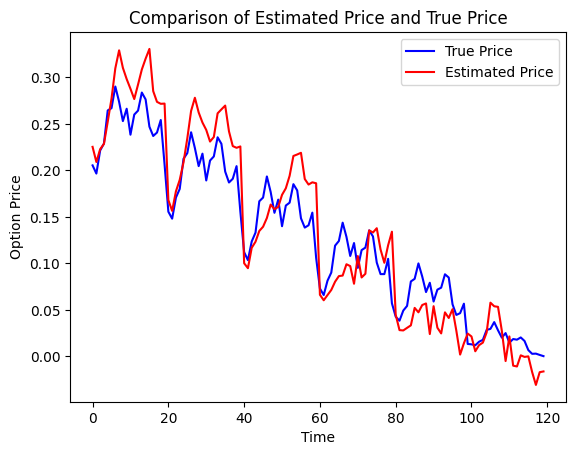

In [13]:
true_price, estimate_price = test(test_loader, args)


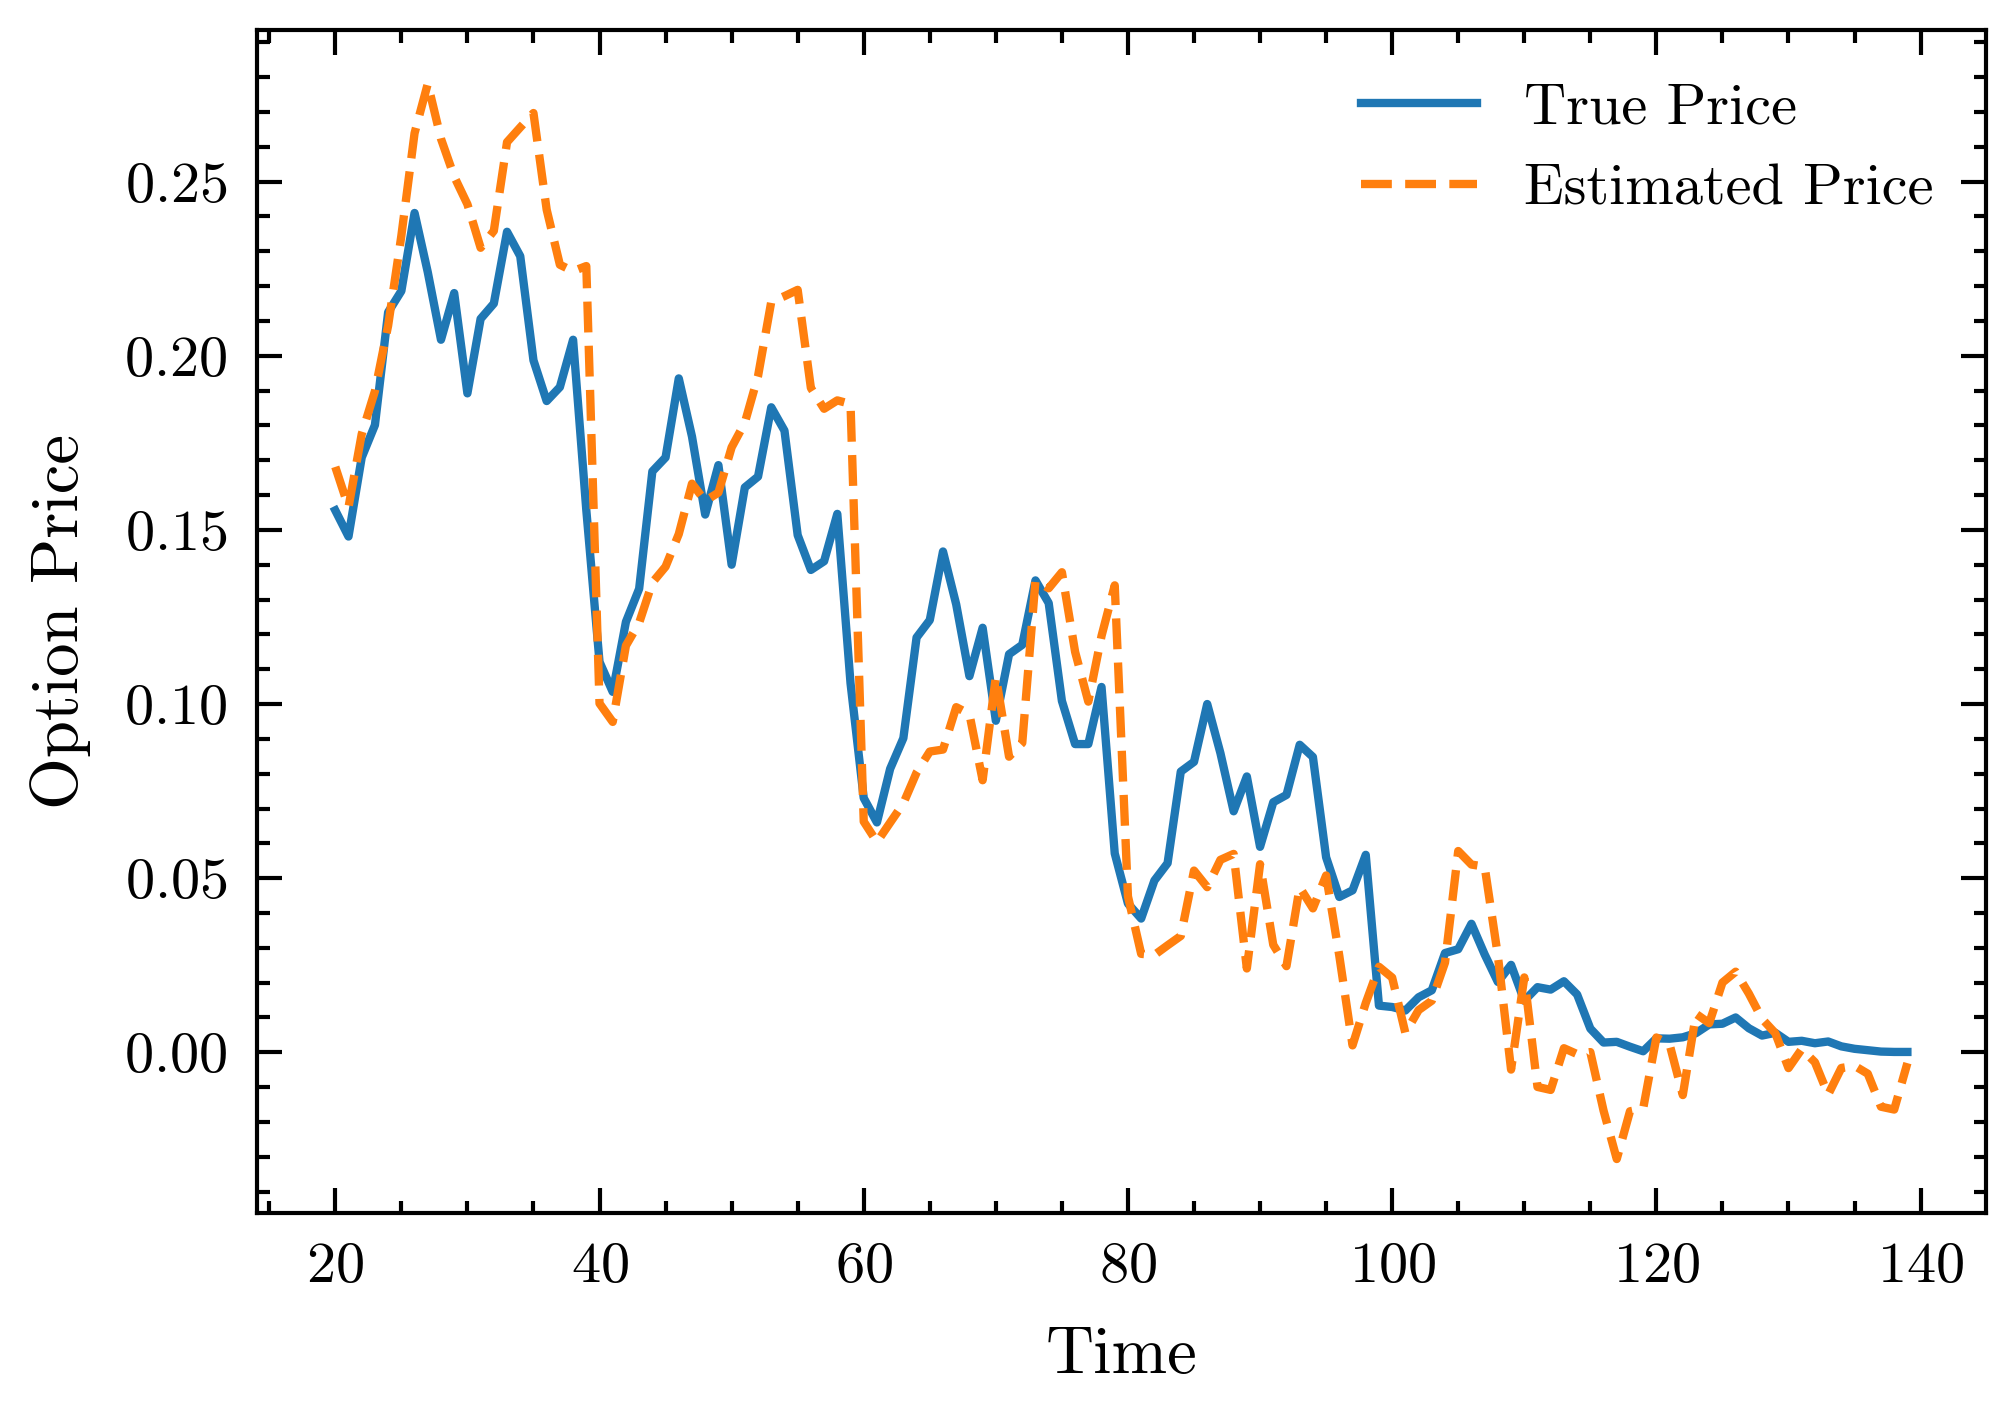

In [19]:
import matplotlib.pyplot as plt
from scienceplots import styles  # 导入样式库
import numpy as np
plot_len = 120
begin_plot = 20
# 启用 IEEE 样式 + 白色背景（无网格）
plt.style.use(["science", "ieee", "no-latex"])  # "no-latex" 避免依赖 LaTeX
plt.rcParams['grid.linewidth'] = 0  # 确保网格关闭

# 设置图表尺寸（IEEE 双栏宽度通常为 3.5 英寸，单栏为 7 英寸）
plt.figure(figsize=(3.5, 2.5))  # 双栏尺寸

# 绘制数据
plt.plot(np.arange(begin_plot, begin_plot+plot_len), true_price[begin_plot:begin_plot+plot_len], 
         color='#1f77b4', linewidth=1, label="True Price")  # IEEE 推荐黑白图
plt.plot(np.arange(begin_plot, begin_plot+plot_len), estimate_price[begin_plot:begin_plot+plot_len], 
         color='#ff7f0e', linestyle='--', linewidth=1, label="Estimated Price")

# 添加标签和标题（IEEE 推荐无标题，此处按需保留）
plt.xlabel('Time', fontsize=8)
plt.ylabel('Option Price', fontsize=8)
plt.legend(fontsize=7, frameon=False)  # 禁用图例边框

# 调整坐标轴字体和刻度
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 紧凑布局
plt.tight_layout()

# 保存为矢量图（IEEE 推荐 .eps 或 .pdf）
plt.savefig("ieee_plot.pdf", bbox_inches='tight', dpi=300)
plt.show()